In [415]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sqlite3
from pandasql import sqldf
import matplotlib.pyplot as plt
import re

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/baldurs-gate-inside-sales-quest/encounters.csv
/kaggle/input/baldurs-gate-inside-sales-quest/adventurer_mart.db


In [416]:
encounters = pd.read_csv('/kaggle/input/baldurs-gate-inside-sales-quest/encounters.csv', parse_dates=['date'])
encounters.head()

,enc_id,date,monster,encounter_type
0,7900-C4E5,2021-09-10,owlbear,combat
1,7901-HRDU,2019-08-19,owlbear,combat
2,7902-4XSZ,2022-06-21,owlbear,sighting
3,7903-JNVC,2023-07-04,owlbear,sighting
4,7904-7HR6,2023-08-14,owlbear,sighting


In [417]:
conn = sqlite3.connect('/kaggle/input/baldurs-gate-inside-sales-quest/adventurer_mart.db')
curr = conn.cursor()

tbl_q = """SELECT name FROM sqlite_master 
WHERE type = "table";"""

curr.execute(tbl_q)
tbl_names = curr.fetchall()
tbl_names

for i in range(len(tbl_names)):
    tbl_names[i] = tbl_names[i][0]

display(tbl_names)

details_adventure_gear = pd.read_sql_query('SELECT * FROM details_adventure_gear;', con=conn)
details_magic_items = pd.read_sql_query('SELECT * FROM details_magic_items;', con=conn)
details_weapons = pd.read_sql_query('SELECT * FROM details_weapons;', con=conn)
details_armor = pd.read_sql_query('SELECT * FROM details_armor;', con=conn)
details_potions = pd.read_sql_query('SELECT * FROM details_potions;', con=conn)
details_poisons = pd.read_sql_query('SELECT * FROM details_poisons;', con=conn)
all_products = pd.read_sql_query('SELECT * FROM all_products;', con=conn)
customers = pd.read_sql_query('SELECT * FROM customers;', con=conn)
sales = pd.read_sql_query('SELECT * FROM sales;', con=conn, parse_dates=['date'])

conn.close()

['details_adventure_gear',
 'details_magic_items',
 'details_weapons',
 'details_armor',
 'details_potions',
 'details_poisons',
 'all_products',
 'customers',
 'sales']

In [418]:
conv_rates = {
    'cp': 1,
    'sp': 10,
    'ep': 50,
    'gp': 100,
    'pp': 1000
}

split_pat = r"([a-zA-Z ]+)"
sub_pat = r"[, ]"


def currency_to_cp(p):
        old = re.split(split_pat,re.sub(sub_pat, "", p))
        new = int(old[0]) * conv_rates[old[1]]
        return new
    
all_products['price'] = all_products['price'].apply(currency_to_cp)
all_products = all_products.rename(columns={"price": "price_in_cp"})

In [419]:
sales['price'] = sales['price'].apply(currency_to_cp)
sales = sales.rename(columns={"price": "price_in_cp"})
sales

,sale_id,date,customer_id,product_id,quantity,price_in_cp,product_name
0,436100-4WBAB,2019-01-03,417383-Z0I083,062-BNo,1,200000,Broom of Flying
1,436101-Q0FOT,2020-10-10,416685-E58HUX,09-Sns,2,100,Sickle
2,435002-10GDM,2018-03-21,417253-ZZKW3G,86-Srs,2,50,Sealing wax
3,435003-IPC8Q,2018-11-15,416187-NKOMV2,19-Brs,4,50,Blanket
4,435004-O6P43,2023-10-19,416520-DEJ31G,296-ICo,1,250000,Instrument of the Bards - Canaith Mandolin
...,...,...,...,...,...,...,...
58199,630802-SVYLS,2021-05-20,417379-DC08FC,266-PCo,1,50000,Pearl of Power
58200,345956-G5BI1,2018-08-11,416643-NBTI22,174-JCo,5,15000,Javelin of Lightning
58201,214441-163MD,2020-09-25,417050-0QABXW,90-Srs,5,2,Soap
58202,762395-70YVC,2022-09-13,416098-LY4LYK,39-Sus,4,100,Sprig of Mistletoe


## Questions to answer:
* What are the most common monsters seen near the city?
* What time of the year are encounters most common?
* Type of Customers that shop here
* Classifying the customers (clustering)

# EDA of Data

In [420]:
encounters['date'].dt.month.value_counts()

date
7     142
8     139
9     116
10     91
6      83
5      21
11      2
Name: count, dtype: int64

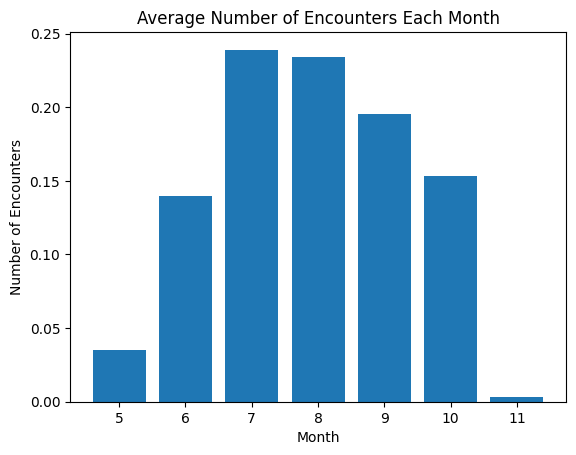

In [421]:
date_counts = encounters['date'].dt.month.value_counts() / len(encounters)

plt.bar(date_counts.index, date_counts)
plt.xlabel('Month')
plt.ylabel('Number of Encounters')
plt.title('Average Number of Encounters Each Month');

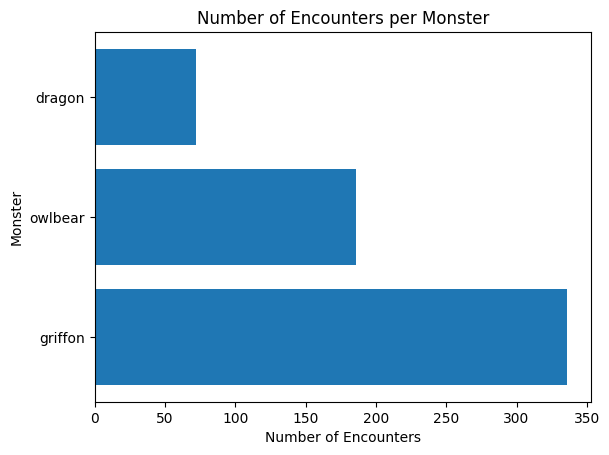

In [422]:
monster_counts = encounters['monster'].value_counts()

plt.barh(monster_counts.index, monster_counts)
plt.xlabel('Number of Encounters')
plt.ylabel('Monster')
plt.title('Number of Encounters per Monster')
plt.show()

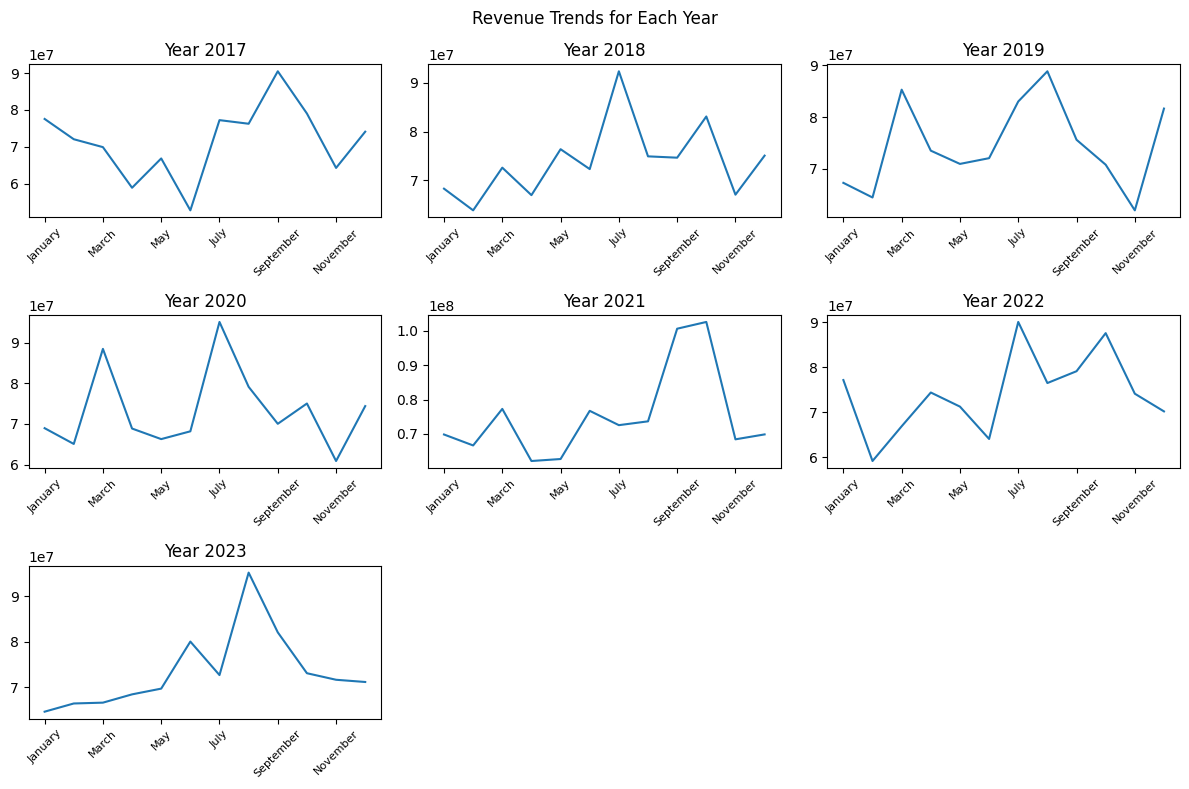

In [428]:
rev = sales[['price_in_cp', 'date']]
rev_sorted = rev.sort_values('price_in_cp').reset_index()


def rev_for_year(year, ax):
    selected_year = rev_sorted[rev_sorted['date'].dt.year == year].copy()
    selected_year['date'] = selected_year['date'].dt.month_name()
    selected_year = selected_year.rename(columns={"date": "month"})
    selected_year = selected_year.groupby('month').sum().reindex(month_order, axis=0)  # Reorder by month
    ax.plot(selected_year.index, selected_year['price_in_cp'], label=str(year))
    ax.set_title(f"Year {year}")
    ax.set_xticks(ax.get_xticks()[::2])
    ax.tick_params(axis='x', labelrotation=45, labelsize=8)

month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

fig, axs = plt.subplots(3, 3, figsize=(12, 8))

for count, ax in enumerate(axs.flatten()[0:7]):
    rev_for_year(years[count], ax)

# Making the last two plots invisible
for ax in axs.flatten()[7:]:
    ax.set_visible(False)

plt.suptitle('Revenue Trends for Each Year')
plt.tight_layout()
plt.show()


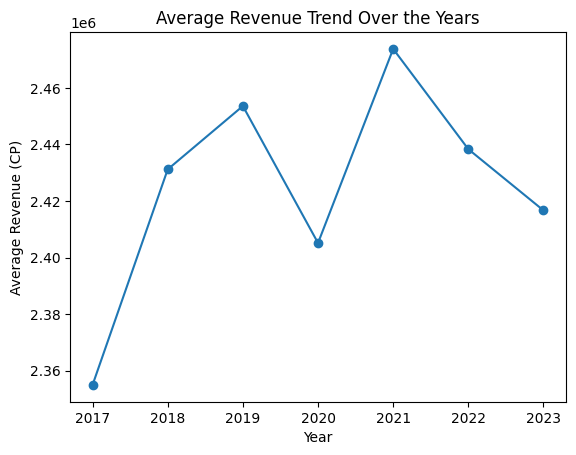

In [425]:
yearly_avg_rev = rev_sorted.groupby(rev_sorted['date'].dt.year)['price_in_cp'].mean()

plt.plot(yearly_avg_rev.index, yearly_avg_rev, marker='o')
plt.xlabel('Year')
plt.ylabel('Average Revenue (CP)')
plt.title('Average Revenue Trend Over the Years')
plt.show()


In [ ]:
top10_prods = sales['product_name'].value_counts()[:10]
top10_prods = temp.sort_values(ascending=True)  # Sort the values in ascending order
plt.barh(temp.index, temp)
plt.xlabel('Popularity Count')
plt.ylabel('Product Name')
plt.title('Top 10 Products by Popularity')
plt.show()


In [430]:
sales

,sale_id,date,customer_id,product_id,quantity,price_in_cp,product_name
0,436100-4WBAB,2019-01-03,417383-Z0I083,062-BNo,1,200000,Broom of Flying
1,436101-Q0FOT,2020-10-10,416685-E58HUX,09-Sns,2,100,Sickle
2,435002-10GDM,2018-03-21,417253-ZZKW3G,86-Srs,2,50,Sealing wax
3,435003-IPC8Q,2018-11-15,416187-NKOMV2,19-Brs,4,50,Blanket
4,435004-O6P43,2023-10-19,416520-DEJ31G,296-ICo,1,250000,Instrument of the Bards - Canaith Mandolin
...,...,...,...,...,...,...,...
58199,630802-SVYLS,2021-05-20,417379-DC08FC,266-PCo,1,50000,Pearl of Power
58200,345956-G5BI1,2018-08-11,416643-NBTI22,174-JCo,5,15000,Javelin of Lightning
58201,214441-163MD,2020-09-25,417050-0QABXW,90-Srs,5,2,Soap
58202,762395-70YVC,2022-09-13,416098-LY4LYK,39-Sus,4,100,Sprig of Mistletoe


In [448]:
from sklearn.cluster import KMeans


X = sales[['price_in_cp', 'product_id', 'quantity', 'customer_id']]
X['month'] = sales['date'].dt.month
X['day_of_week'] = sales['date'].dt.dayofweek
X = pd.get_dummies(X)
X = X.astype('float64')

/tmp/ipykernel_42/4258671681.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['month'] = sales['date'].dt.month
/tmp/ipykernel_42/4258671681.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['day_of_week'] = sales['date'].dt.dayofweek


In [449]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt


distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(2, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k, n_init=10).fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

In [450]:
for key, val in mapping2.items():
    print(f'{key} : {val}')

2 : 1820932061846586.0
3 : 692798577490649.8
4 : 410267610947076.75
5 : 206292795440469.03
6 : 94490649187545.92
7 : 50256904413396.516
8 : 34231682235173.055
9 : 25302295635836.625


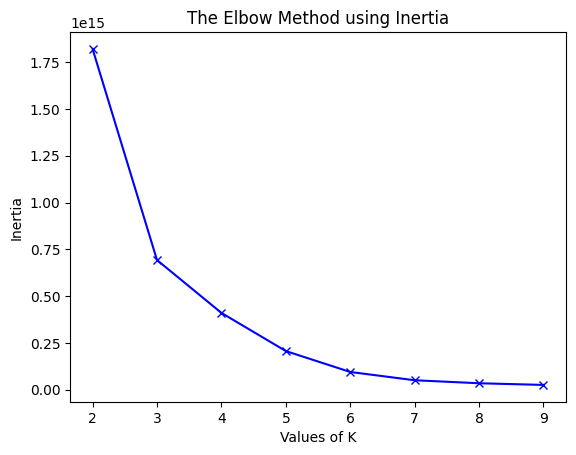

In [451]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [453]:
kmeanModel = KMeans(n_clusters=3, n_init=10).fit(X)
kmeanModel.fit(X)
labels = kmeanModel.labels_

plt.scatter(sales['price_in_cp', ''])

In [463]:
sales['label'] = labels
clustered_customers = sales[['customer_id', 'label']]
clustered_customers

,customer_id,label
0,417383-Z0I083,0
1,416685-E58HUX,0
2,417253-ZZKW3G,0
3,416187-NKOMV2,0
4,416520-DEJ31G,0
...,...,...
58199,417379-DC08FC,0
58200,416643-NBTI22,0
58201,417050-0QABXW,0
58202,416098-LY4LYK,0


In [481]:
key_presence = [key in customers['customer_id'].values for key in cluster_dict.keys()]
indices_where_false = np.where(np.logical_not(key_presence))[0]

print(indices_where_false)
cluster_dict.pop('416054-6VZ41N', None)

[596]


2

In [485]:
# Assuming cluster_dict is your dictionary
df = pd.DataFrame(list(cluster_dict.items()), columns=['customer_id', 'label'])

# If 'customer_id' is supposed to be the index, you can set it like this:
df.set_index('customer_id', inplace=True)

# Display the DataFrame
df

,label
customer_id,
417383-Z0I083,0
416685-E58HUX,0
417253-ZZKW3G,0
416187-NKOMV2,0
416520-DEJ31G,0
...,...
416303-MJ70E3,0
417203-2GUWJP,0
416445-IQ2FA3,0


In [489]:
customers.set_index('customer_id', inplace=True)  # Set 'customer_id' as index
customers_labelled = pd.merge(customers, df, left_index=True, right_index=True)
customers_labelled

,name,sex,race,age,class,label
customer_id,,,,,,
415996-753LC5,Veklani Daargen,female,Elf,661,Warlock,0
415997-8DRC11,Kasaki Wygarthe,female,Half-Elf,100,Wizard,0
415998-ERTJ5P,Rosalyn Faringray,female,Halfling,40,Barbarian,0
415999-HT0HL9,Atalya Webb,female,Tiefling,55,Monk,0
416000-XPSEIM,Grenenzel Lyfalia,female,Half-Orc,43,Bard,0
...,...,...,...,...,...,...
417414-CTM09H,Arnan Ramcrown,male,Tiefling,27,Wizard,0
417415-ZBGTJ5,Tavon Stormchapel,male,Dwarf,264,Warlock,0
417416-4696QZ,Dodd Fryft,male,Half-Orc,19,Cleric,2


In [496]:
sales

,sale_id,date,customer_id,product_id,quantity,price_in_cp,product_name,label
0,436100-4WBAB,2019-01-03,417383-Z0I083,062-BNo,1,200000,Broom of Flying,0
1,436101-Q0FOT,2020-10-10,416685-E58HUX,09-Sns,2,100,Sickle,0
2,435002-10GDM,2018-03-21,417253-ZZKW3G,86-Srs,2,50,Sealing wax,0
3,435003-IPC8Q,2018-11-15,416187-NKOMV2,19-Brs,4,50,Blanket,0
4,435004-O6P43,2023-10-19,416520-DEJ31G,296-ICo,1,250000,Instrument of the Bards - Canaith Mandolin,0
...,...,...,...,...,...,...,...,...
58199,630802-SVYLS,2021-05-20,417379-DC08FC,266-PCo,1,50000,Pearl of Power,0
58200,345956-G5BI1,2018-08-11,416643-NBTI22,174-JCo,5,15000,Javelin of Lightning,0
58201,214441-163MD,2020-09-25,417050-0QABXW,90-Srs,5,2,Soap,0
58202,762395-70YVC,2022-09-13,416098-LY4LYK,39-Sus,4,100,Sprig of Mistletoe,0


In [513]:
cluster_centers = kmeanModel.cluster_centers_
feature_names = kmeanModel.feature_names_in_

cluster_df = pd.DataFrame(cluster_centers, columns=feature_names)

# Transpose the DataFrame for a more readable format
cluster_df = cluster_df.T

# Rename the columns for clarity
cluster_df.columns = ['Cluster 1', 'Cluster 2', 'Cluster 3']

# Display the DataFrame
cls_1 = cluster_df[['Cluster 1']].sort_values('Cluster 1', ascending=False)[:5]
cls_2 = cluster_df[['Cluster 2']].sort_values('Cluster 2', ascending=False)[:5]
cls_3 = cluster_df[['Cluster 3']].sort_values('Cluster 3', ascending=False)[:5]

In [521]:
np.argmax([cls_1.iloc[0,0], cls_2.iloc[0,0], cls_3.iloc[0,0]])

1